
## Table of Contents



1. [Load the reviews](#loadData)
2. [Extract frequently mentioned hotel aspects](#extractNouns)
3. [Extract document and sentence sentiment](#extractSentiment)
4. [Identify nons that drive sentiment](#sentenceSentiment)
5. [Targets sentiment analysis](#targetedSentiment)
6. [Summary](#summary)



Begin by importing and initializing some helper libs that are used throughout the notebook.

In [2]:
import os, types
import json
import pandas as pd
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

import matplotlib.pyplot as plt

In [3]:
import watson_nlp

Detect if the notebook is running in a CPU- or GPU-based environment. Depending on this information, you may load GPU- or CPU-optimized NLP models for sentiment and targets sentiment extraction.

In [4]:
gpu_available = False
try:
    hw_spec = os.environ['RUNTIME_HARDWARE_SPEC']
    if 'num_gpu' in json.loads(hw_spec):
        gpu_available = True
except:
    pass

<a id="loadData"></a>
## Load the reviews

You will load the hotel reviews into a DataFrame.

The *OpinRank Review* data set contains user reviews for hotels with separate files for each hotel. The sample combines two of these files to analyze and compare the sentiment for two different hotels. The combined data set contains four columns with the hotel name, the review date, a title and the review text.

In [5]:
# load data set into a dataframe
buffer = wslib.load_data("hotel_reviews.csv")
hotel_df = pd.read_csv(buffer)

# save the hotel names for later filter steps
hotel_a = 'Hudson Hotel'
hotel_b = 'Westin New York at Times Square'

# preview the data set
hotel_df.head(3)

,Hotel,Date,Review Title,Review
0,Hudson Hotel,Nov 26 2009,Great Hotel!,"We stayed at the Hudson Hotel for 5 nights and after reading a lot of bad reviews was very pleased with the hotel. Rooms were very clean and although small, bigger than I was expecting. Perfect location within walking distance to Times Square and 5th Avenue. Had a great stay here and would definately reccommend it!!!"
1,Hudson Hotel,Nov 25 2009,Great Hotel in Great Location,"I just spent 3 days at the Hudson Hotel and highly recommend it! The room was clean, (a bit small) the bed was comfortable and the hotel is a great mix of trendy and urban chic. the lobby is fun and interesting, exposed brick and and ivy on the walls and ceiling. the front desk and concierge staff were polite and accomodating. the housekeeping staff, always smiled and said good morning. The gy..."
2,Hudson Hotel,Nov 24 2009,tiny rooms - GREAT PRICES,no sign outside = difficult to find: we walked by three times without finding the entranceenormous lobby with nearly no light and hectic music foregroundtiny room: - nearly could not get up and down from the toilet and turn around in bathroom- impossible to be in two people without continuosly stepping out of the way- banging doors - loud neighbourhood in the night--- in case you want a room w...


Next define a set of stopwords that you don't want to use in your context about hotels in New York.

In [6]:
# stopwords in our context
stopwords = ['NYC', 'HUDSON', 'HOTEL', 'HUDSON HOTEL', 'WESTIN', 'NEW', 'YORK', 'NEW YORK', 'WESTIN', 
             'WESTIN TIMES SQUARE', 'TIMES SQUARE', 'TIMES', 'SQUARE', 'TIME']

<a id="extractNouns"></a>
## Extract frequently mentioned hotel aspects

You will extract the most frequently mentioned aspects (nouns) in the reviews for each hotel to get to know what the guests are talking about in their reviews.

For this, you will use the Watson Natural Language Processing pre-trained syntax model to extract the most frequently used nouns from the reviews. These nouns help you to understand what the main message of each review is.

Load the Watson Natural Language Processing syntax model:

In [7]:
syntax_model = watson_nlp.load('syntax_izumo_en_stock')

### Extract and store nouns and their lemmas

The syntax model performs part-of-speech tagging (for nouns, pronouns, verbs, and so on) so that you can filter out all nouns from the reviews. Instead of retrieving the nouns as they occur in the review, the lemmatized version of the nouns (for example, `rooms` -> `room`) is stored. This allows you to create more accurate statistics over all noun occurrences.

Use the helper functions to identify the lemma form of nouns in the review text. 

In [8]:
# Helper methods
# extract the lemmatized nouns
def extract_nouns(review_text):
    syntax_result = syntax_model.run(review_text, parsers=('token', 'lemma', 'part_of_speech', 'sentence'))
    # filter nouns
    nouns = [token['lemma'] for token in syntax_result.to_dict()['tokens'] if ((token['part_of_speech'] == 'POS_PROPN' or token['part_of_speech'] == 'POS_NOUN') and len(token['lemma']) > 2)] 
    # remove stopwords
    nouns = [noun for noun in nouns if noun.upper() not in stopwords]
    return list(nouns)

# create a new dataframe with the corresponding nouns
def create_noun_dataframe(df):
    nouns = df['Review'].apply(lambda text: extract_nouns(text))
    noun_df = pd.DataFrame(nouns)
    noun_df.rename(inplace=True, columns={'Review':'Nouns'})
    return noun_df


Extract the lemmatized nouns and show them with the review text in which they occurred.

In [9]:
noun_df = create_noun_dataframe(hotel_df)
hotel_noun_df = hotel_df[['Hotel', 'Review']].merge(noun_df, how='left', left_index=True, right_index=True)
hotel_noun_df.head()

,Hotel,Review,Nouns
0,Hudson Hotel,"We stayed at the Hudson Hotel for 5 nights and after reading a lot of bad reviews was very pleased with the hotel. Rooms were very clean and although small, bigger than I was expecting. Perfect location within walking distance to Times Square and 5th Avenue. Had a great stay here and would definately reccommend it!!!","[night, lot, review, room, location, walking, distance, avenue, stay]"
1,Hudson Hotel,"I just spent 3 days at the Hudson Hotel and highly recommend it! The room was clean, (a bit small) the bed was comfortable and the hotel is a great mix of trendy and urban chic. the lobby is fun and interesting, exposed brick and and ivy on the walls and ceiling. the front desk and concierge staff were polite and accomodating. the housekeeping staff, always smiled and said good morning. The gy...","[day, room, bit, bed, mix, lobby, brick, ivy, wall, ceiling, desk, concierge, staff, housekeeping, staff, morning, gym, equipment, staff, member, location, subway, line, trip, center, park, center, side, proximity, Warner, center, shopping, restaurant, course, Whole, Food, morning, juice, value, Bar, kind, place, drink]"
2,Hudson Hotel,no sign outside = difficult to find: we walked by three times without finding the entranceenormous lobby with nearly no light and hectic music foregroundtiny room: - nearly could not get up and down from the toilet and turn around in bathroom- impossible to be in two people without continuosly stepping out of the way- banging doors - loud neighbourhood in the night--- in case you want a room w...,"[lobby, light, music, room, toilet, bathroom, people, way, door, neighborhood, night, case, room, space, room, night, weekend, low]"
3,Hudson Hotel,"The hotel was unmarked from the front, but inside had an absolutely goregous lobby and entrance area. Bellman and front desk staff were very helpful. Room was trendy and clean but exceptionally TINY. Even bathtub and toilet were minature. Hallways were very dark which I didnt love. We only stayed one night but had no issues with room being loud, etc. I would return, but for the price would pro...","[front, lobby, entrance, area, bellman, desk, staff, room, bathtub, toilet, hallway, love, night, issue, room, price, space]"
4,Hudson Hotel,"I took my husband to NYC for his birthday for a 1-night getaway. We got a good promotional price for our room, which is the only reason we would have chosen this hotel because we knew up front that the room were quite small for a pretty big pricetag. It is, however, a nice place with some funky characteristics and the room size was not a major issue as we didn't plan to spend a lot of time the...","[husband, birthday, night, getaway, price, room, reason, room, place, characteristic, room, size, issue, lot, size, problem, bathroom, husband, toilet, location, problem, floor, room, St., night, floor, room, car, amount, car, horn, night, ambulance, police, siren, group, people, hour, night, damper, experience, atrium, facing, room, noise, level]"


### Display the 20 most frequent nouns as a bar chart and word cloud

Use the `explode` function to transform the noun list into separate rows for each noun. That way, you can count the occurrences for each noun in a subsequent step.

In [10]:
exp_nouns_a = hotel_noun_df.query("Hotel == @hotel_a").explode('Nouns')
exp_nouns_b = hotel_noun_df.query("Hotel == @hotel_b").explode('Nouns')

Plot the most frequent nouns as a bar chart for each hotel side by side:

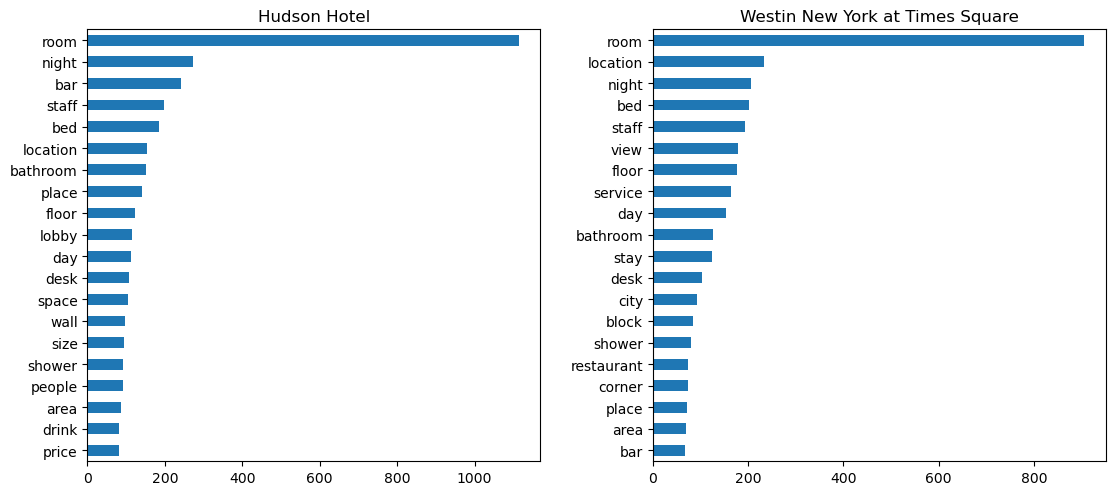

In [11]:
figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
figure.tight_layout(pad=5)
exp_nouns_a['Nouns'].value_counts().head(20).sort_values().plot(kind='barh', ax=ax1) 
ax1.title.set_text(hotel_a)
exp_nouns_b['Nouns'].value_counts().head(20).sort_values().plot(kind='barh', ax=ax2) 
ax2.title.set_text(hotel_b)

plt.show()

<a id="extractSentiment"></a>
## Extract document and sentence sentiment

Are guests talking positively or negatively about the hotels? Sentiment can be extracted for the complete review and for individual sentences. The sentiment extraction helpers can extract sentiment both at the document and sentence levels. 

The first charts focus on the sentiment for the complete review.

As a first step, load the sentiment model for English. If the notebook is running in a CPU-based environment, the CPU-optimized sentiment model is loaded. The GPU model may used for both GPUs and CPUs, but it is slower on CPU-based runtimes.

In [12]:
if gpu_available:
    sentiment_model = watson_nlp.load('sentiment-aggregated_transformer-workflow_multilingual_slate.153m.distilled')
else:
    sentiment_model = watson_nlp.load('sentiment-aggregated_transformer-workflow_multilingual_slate.153m.distilled-cpu')

### Extract the overall sentiment of the review and the sentiment for each sentence

Helper functions extract the sentiment in the review text and create a dataframe. 

In [13]:
def get_sentence_sentiment(sentimentprob):
    top_score = sentimentprob.positive
    sentiment_label = 'SENT_POSITIVE'
    if sentimentprob.negative > sentimentprob.positive:
        top_score = sentimentprob.negative
        sentiment_label = 'SENT_NEGATIVE'
    if sentimentprob.neutral > top_score:
        sentiment_label = 'SENT_NEUTRAL'
    return sentiment_label

def extract_sentiment(review_text):

    # run the sentiment model on the input text
    sentiment_result = sentiment_model.run(review_text)
    
    # use a helper function to retrieve the sentiment of the individual sentences
    sentence_sentiment = [(sent.span.text, get_sentence_sentiment(sent.sentimentprob)) for sent in sentiment_result.document_sentiment.sentiment_mentions]
    
    document_sentiment = sentiment_result.document_sentiment.to_dict()['label']
    return (sentence_sentiment, document_sentiment)

from tqdm.notebook import tqdm
tqdm.pandas(colour='green')

# Helper method to create a new dataframe that contains the sentiment for each review
# For better progress feedback, the cell is using `progress_apply` from the `tqdm` library. 
# You can also use `apply` from `pandas` directly, i.e. `df['Review'].apply(..)`
def create_sentiment_dataframe(df):
    sentiment = df['Review'].progress_apply(lambda text: extract_sentiment(text))
    sentiment_df = pd.DataFrame.from_records(sentiment, columns=('Sentence Sentiment', 'Document Sentiment'))
    return sentiment_df

Extract the sentiment and display it with the review text. <br/> **Note:** this cell will run for several minutes. 

In [14]:
sentiment_df = create_sentiment_dataframe(hotel_df)
hotel_sentiment_df = hotel_df[['Hotel','Review']].merge(sentiment_df, how='left', left_index=True, right_index=True)
hotel_sentiment_df.head()

  0%|          | 0/658 [00:00<?, ?it/s]

,Hotel,Review,Sentence Sentiment,Document Sentiment
0,Hudson Hotel,"We stayed at the Hudson Hotel for 5 nights and after reading a lot of bad reviews was very pleased with the hotel. Rooms were very clean and although small, bigger than I was expecting. Perfect location within walking distance to Times Square and 5th Avenue. Had a great stay here and would definately reccommend it!!!","[(We stayed at the Hudson Hotel for 5 nights and after reading a lot of bad reviews was very pleased with the hotel., SENT_POSITIVE), (Rooms were very clean and although small, bigger than I was expecting., SENT_POSITIVE), (Perfect location within walking distance to Times Square and 5th Avenue., SENT_POSITIVE), (Had a great stay here and would definately reccommend it!!!, SENT_POSITIVE)]",SENT_POSITIVE
1,Hudson Hotel,"I just spent 3 days at the Hudson Hotel and highly recommend it! The room was clean, (a bit small) the bed was comfortable and the hotel is a great mix of trendy and urban chic. the lobby is fun and interesting, exposed brick and and ivy on the walls and ceiling. the front desk and concierge staff were polite and accomodating. the housekeeping staff, always smiled and said good morning. The gy...","[(I just spent 3 days at the Hudson Hotel and highly recommend it!, SENT_POSITIVE), (The room was clean, (a bit small) the bed was comfortable and the hotel is a great mix of trendy and urban chic., SENT_POSITIVE), (the lobby is fun and interesting, exposed brick and and ivy on the walls and ceiling., SENT_POSITIVE), (the front desk and concierge staff were polite and accomodating., SENT_POSIT...",SENT_POSITIVE
2,Hudson Hotel,no sign outside = difficult to find: we walked by three times without finding the entranceenormous lobby with nearly no light and hectic music foregroundtiny room: - nearly could not get up and down from the toilet and turn around in bathroom- impossible to be in two people without continuosly stepping out of the way- banging doors - loud neighbourhood in the night--- in case you want a room w...,[(no sign outside = difficult to find: we walked by three times without finding the entranceenormous lobby with nearly no light and hectic music foregroundtiny room: - nearly could not get up and down from the toilet and turn around in bathroom- impossible to be in two people without continuosly stepping out of the way- banging doors - loud neighbourhood in the night--- in case you want a room...,SENT_NEGATIVE
3,Hudson Hotel,"The hotel was unmarked from the front, but inside had an absolutely goregous lobby and entrance area. Bellman and front desk staff were very helpful. Room was trendy and clean but exceptionally TINY. Even bathtub and toilet were minature. Hallways were very dark which I didnt love. We only stayed one night but had no issues with room being loud, etc. I would return, but for the price would pro...","[(The hotel was unmarked from the front, but inside had an absolutely goregous lobby and entrance area., SENT_NEGATIVE), (Bellman and front desk staff were very helpful., SENT_POSITIVE), (Room was trendy and clean but exceptionally TINY., SENT_POSITIVE), (Even bathtub and toilet were minature., SENT_NEGATIVE), (Hallways were very dark which I didnt love., SENT_NEGATIVE), (We only stayed one ni...",SENT_NEGATIVE
4,Hudson Hotel,"I took my husband to NYC for his birthday for a 1-night getaway. We got a good promotional price for our room, which is the only reason we would have chosen this hotel because we knew up front that the room were quite small for a pretty big pricetag. It is, however, a nice place with some funky characteristics and the room size was not a major issue as we didn't plan to spend a lot of time the...","[(I took my husband to NYC for his birthday for a 1-night getaway., SENT_POSITIVE), (We got a good promotional price for our room, which is the only reason we would have chosen this hotel because we knew up front that the room were quite small for a pretty big pricetag., SENT_POSITIVE), (It

### Compare the overall review sentiment across hotels

The following pie charts show that the Westin Hotel has a better positive to negative sentiment ratio than the Hudson Hotel.

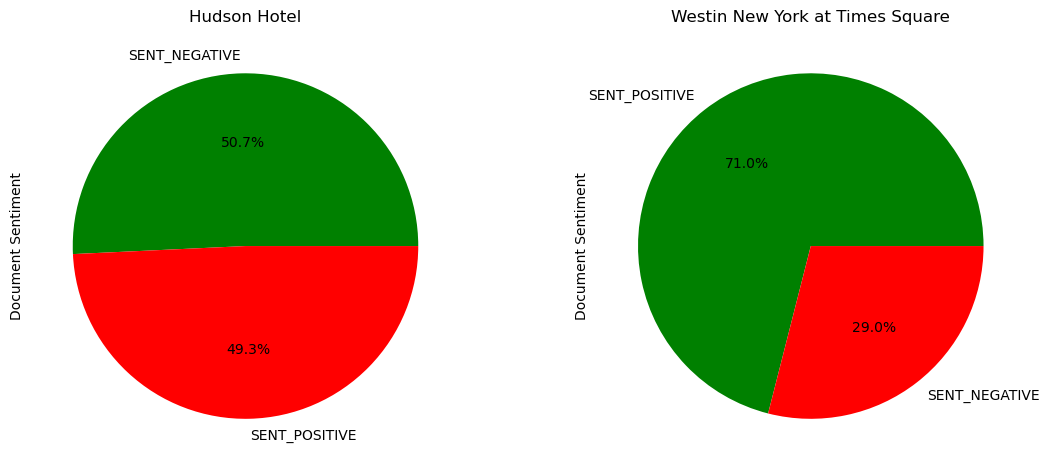

In [15]:
# Show the sentiment for each review
sentiment_a = hotel_sentiment_df.query("Hotel == @hotel_a")
sentiment_b = hotel_sentiment_df.query("Hotel == @hotel_b")

import matplotlib.pyplot as plt

# plot the figures for each hotel side by side
figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
figure.tight_layout(pad=5)
sentiment_a['Document Sentiment'].value_counts().plot(kind='pie', ax=ax1, colors=['g','r','b'], autopct='%1.1f%%') 
ax1.title.set_text(hotel_a)
sentiment_b['Document Sentiment'].value_counts().plot(kind='pie', ax=ax2, colors=['g','r','b'], autopct='%1.1f%%') 
ax2.title.set_text(hotel_b)

plt.show()

<a id="sentenceSentiment"></a>
## Identify nouns that drive sentiment

Now you will try and identify the most frequently used nouns in the sentences with positive or negative sentiment.

For this you need the `sentiment_df` dataframe from the previous section, which contains the sentence sentiment with the document sentiment for the reviews.

For each review, you create a row for each sentence with the corresponding sentiment:

In [16]:
hotel_sentence_sentiment_df = hotel_df[['Hotel']].merge(sentiment_df[['Sentence Sentiment']], how='left', left_index=True, right_index=True)
exp_hotel_sentence_sentiment_df = hotel_sentence_sentiment_df.explode('Sentence Sentiment')
exp_hotel_sentence_sentiment_df.reset_index(inplace=True, drop=True)
exp_hotel_sentence_sentiment_df[['Sentence', 'Sentiment']] = pd.DataFrame(exp_hotel_sentence_sentiment_df['Sentence Sentiment'].tolist(), 
                                                                          index=exp_hotel_sentence_sentiment_df.index)
exp_hotel_sentence_sentiment_df.head(3)

,Hotel,Sentence Sentiment,Sentence,Sentiment
0,Hudson Hotel,"(We stayed at the Hudson Hotel for 5 nights and after reading a lot of bad reviews was very pleased with the hotel., SENT_POSITIVE)",We stayed at the Hudson Hotel for 5 nights and after reading a lot of bad reviews was very pleased with the hotel.,SENT_POSITIVE
1,Hudson Hotel,"(Rooms were very clean and although small, bigger than I was expecting., SENT_POSITIVE)","Rooms were very clean and although small, bigger than I was expecting.",SENT_POSITIVE
2,Hudson Hotel,"(Perfect location within walking distance to Times Square and 5th Avenue., SENT_POSITIVE)",Perfect location within walking distance to Times Square and 5th Avenue.,SENT_POSITIVE


Extract nouns from the sentence sentiment dataframe:

In [17]:
sent_level_nouns = exp_hotel_sentence_sentiment_df['Sentence'].apply(lambda text: extract_nouns(text))
sent_level_nouns_df = pd.DataFrame(sent_level_nouns)
sent_level_nouns_df.rename(inplace=True, columns={'Sentence':'Nouns'})
sentences_noun_df = exp_hotel_sentence_sentiment_df[['Hotel', 'Sentence', 'Sentiment']].merge(sent_level_nouns_df, how='left', left_index=True, right_index=True)
sentences_noun_df.head(3)

,Hotel,Sentence,Sentiment,Nouns
0,Hudson Hotel,We stayed at the Hudson Hotel for 5 nights and after reading a lot of bad reviews was very pleased with the hotel.,SENT_POSITIVE,"[night, lot, review]"
1,Hudson Hotel,"Rooms were very clean and although small, bigger than I was expecting.",SENT_POSITIVE,[room]
2,Hudson Hotel,Perfect location within walking distance to Times Square and 5th Avenue.,SENT_POSITIVE,"[location, walking, distance, avenue]"


Explode nouns and create dataframes for positive and negative sentiments for each hotel: 

In [18]:
exp_sent_nouns = sentences_noun_df.explode('Nouns')[['Hotel', 'Sentiment', 'Nouns']]
neg_nouns_a = exp_sent_nouns.query("Hotel == @hotel_a and Sentiment == 'SENT_NEGATIVE'")
neg_nouns_b = exp_sent_nouns.query("Hotel == @hotel_b and Sentiment == 'SENT_NEGATIVE'")
pos_nouns_a = exp_sent_nouns.query("Hotel == @hotel_a and Sentiment == 'SENT_POSITIVE'")
pos_nouns_b = exp_sent_nouns.query("Hotel == @hotel_b and Sentiment == 'SENT_POSITIVE'")

### Show the most frequent nouns in positive sentences

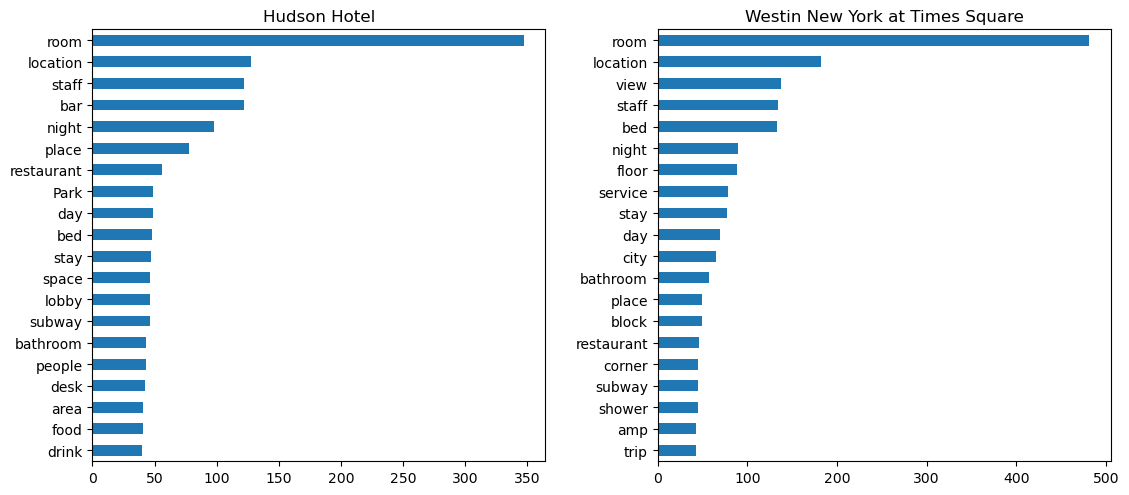

In [19]:
figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
figure.tight_layout(pad=5)
pos_nouns_a['Nouns'].value_counts().head(20).sort_values().plot(kind='barh', ax=ax1) 
ax1.title.set_text(hotel_a)
pos_nouns_b['Nouns'].value_counts().head(20).sort_values().plot(kind='barh', ax=ax2) 
ax2.title.set_text(hotel_b)

plt.show()

### Show the most frequent nouns in negative sentences

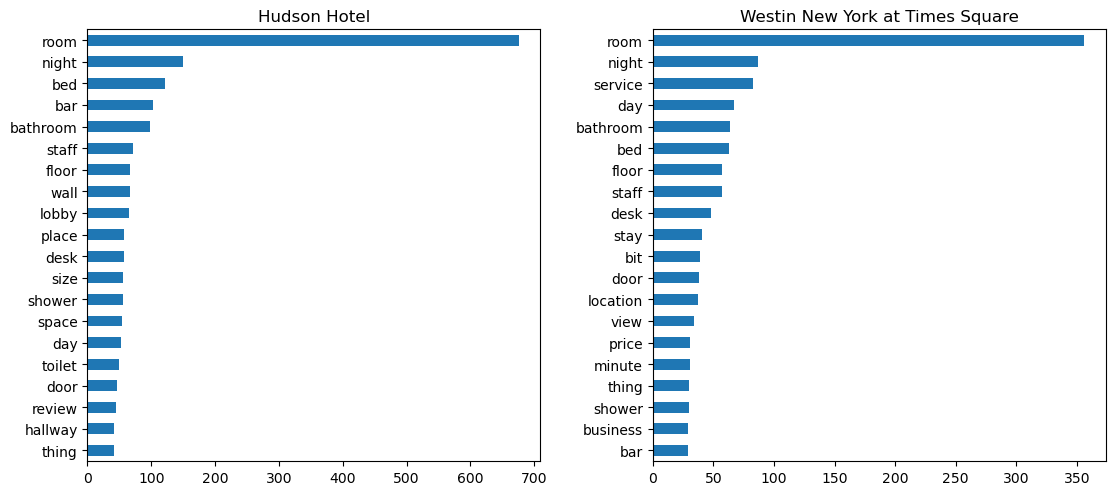

In [20]:
figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
figure.tight_layout(pad=5)
neg_nouns_a['Nouns'].value_counts().head(20).sort_values().plot(kind='barh', ax=ax1) 
ax1.title.set_text(hotel_a)
neg_nouns_b['Nouns'].value_counts().head(20).sort_values().plot(kind='barh', ax=ax2) 
ax2.title.set_text(hotel_b)

plt.show()

### Show nouns that drive sentiment for each hotel

Create a crosstab to show the relationship between the nouns and the resulting sentence sentiment, and correlate them. The darker the cell, the more often does a noun occur in a sentence of a certain polarity. 

In [21]:
# create a data frame that only contains the nouns that appear more than 100 times in the reviews
nounFrequency = exp_sent_nouns['Nouns'].value_counts()
frequent_values = nounFrequency[nounFrequency >= 100].index
freq_sent_nouns = exp_sent_nouns[exp_sent_nouns['Nouns'].isin(frequent_values)]

freq_sent_nouns_hotel_a = freq_sent_nouns.query("Hotel == @hotel_a")
freq_sent_nouns_hotel_b = freq_sent_nouns.query("Hotel == @hotel_b")

<Axes: title={'center': 'Westin New York at Times Square'}, xlabel='Sentiment', ylabel='Nouns'>

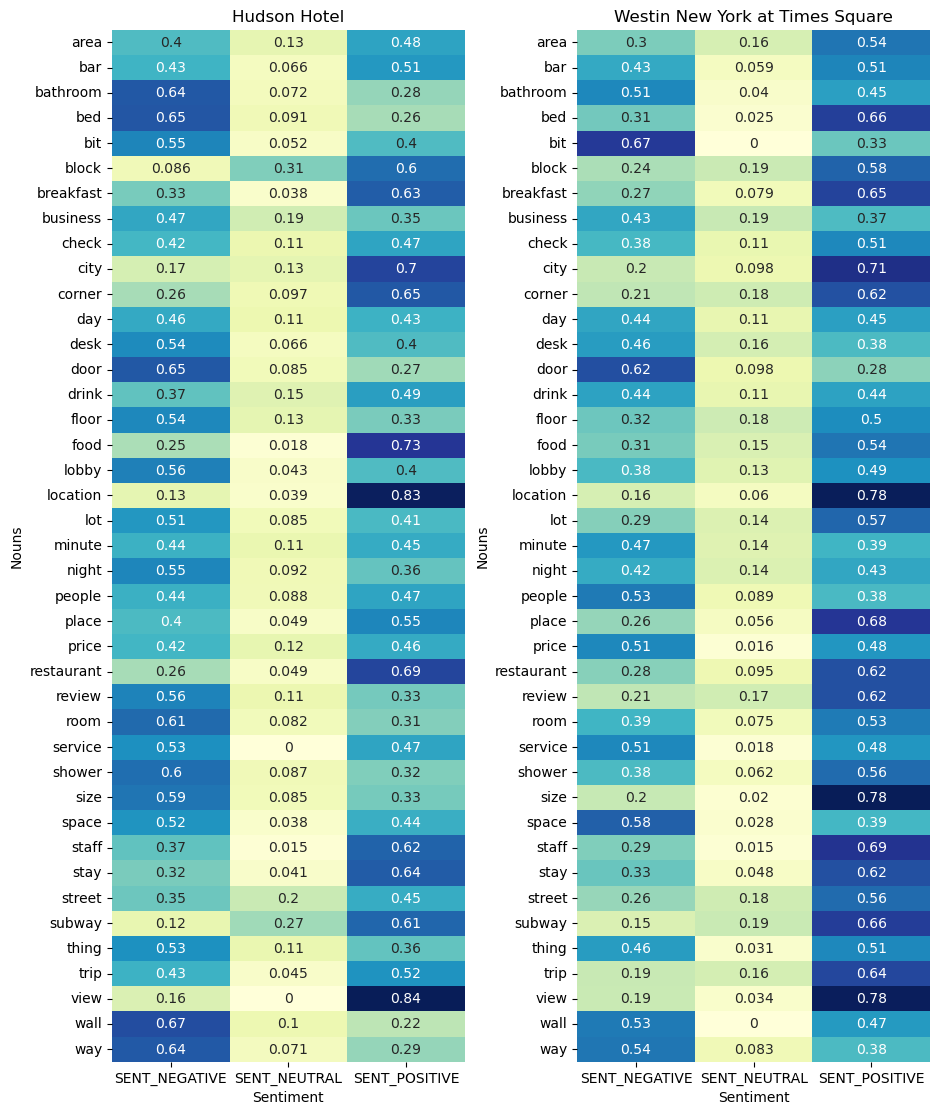

In [22]:
import seaborn as sns

figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,12))
figure.tight_layout(pad=5)

ax1.title.set_text(hotel_a)
ax2.title.set_text(hotel_b)

#sns.set(rc = {'figure.figsize':(5,12)})
sns.heatmap(pd.crosstab(freq_sent_nouns_hotel_a['Nouns'], freq_sent_nouns_hotel_a['Sentiment'], normalize='index'), 
            annot=True, cbar=False, cmap="YlGnBu", ax=ax1)
sns.heatmap(pd.crosstab(freq_sent_nouns_hotel_b['Nouns'], freq_sent_nouns_hotel_b['Sentiment'], normalize='index'), 
            annot=True, cbar=False, cmap="YlGnBu", ax=ax2)


Comparing the two hotels yields various findings, including the following:
- `bed` seems to be rated more negatively in the Hudson Hotel. It appears much more often in a negative context than at the Westin Hotel.
- `location` is a positive factor for both hotels.
- `size` of the hotel room is rated more positively at the Westin Hotel than the Hudson Hotel.
    

<a id="targetedSentiment"></a>
## Targets sentiment analysis

The charts above showed the sentiment of the reviews and individual sentences. Watson Natural Language Processing offers an even more granular level of sentiment extraction. The *Targets Sentiment Extraction Workflow* automatically extracts targets and the sentiment expressed towards each target term for each sentence in the input document. It can handle multiple targets with different sentiments in one sentence. In contrast, our earlier analysis above classified all the nouns in a sentence with the same sentiment. 

For example, consider the text *“The served food was delicious, yet the service was slow.”*. The algorithm automatically identifies the positive sentiment towards *“food”* and the negative sentiment towards *“service”*. Note: the *Targets Sentiment Extraction Workflow* will not detect targets with "neutral" sentiment, as there is technically no sentiment.

Let's use the *Targets Sentiment Extraction* to identify the sentiment of the different hotel review aspects.

As a first step, load the targeted transformer sentiment model. If the notebook is running in a CPU-based environment, the CPU-optimized targets sentiment model is loaded. The GPU model may used for both GPUs and CPUs, but it is slower on CPU-based runtimes.

In [23]:
if gpu_available:
    targeted_sentiment_model = watson_nlp.load('targets-sentiment_transformer-workflow_multilingual_slate.153m.distilled')
else:
    targeted_sentiment_model = watson_nlp.load('targets-sentiment_transformer-workflow_multilingual_slate.153m.distilled-cpu')

The *Targets Sentiment Extraction* automatically identifies targets with sentiment in the input texts. You use a helper method to run the model on a review text.

In [24]:
def extract_targeted_sentiment(review_text):
    # run the targeted sentiment model on the input text
    sentiment_result = targeted_sentiment_model.run(review_text)
    
    # iterate over all target aspects
    target_sent = [(sent[0], sent[1].to_dict()['label']) for sent in sentiment_result.targeted_sentiments.items()]
    # remove stopwords from aspects
    target_sent = [sent for sent in target_sent if sent[0].upper() not in stopwords]
    return target_sent

Extract the targeted sentiment for all reviews. <br/> **Note:** this cell will run for several minutes. For better progress feedback, the cell is using `progress_apply` from the `tqdm` library. You can also use `apply` from `pandas` directly, i.e. `hotel_df['Review'].apply(..)`

In [25]:
target_sentiment = hotel_df['Review'].progress_apply(lambda text: extract_targeted_sentiment(text))
target_sentiment_df = pd.DataFrame({'Targeted Sentiment': target_sentiment})

hotel_as_df = hotel_df[['Hotel', 'Review']].merge(target_sentiment_df, how='left', left_index=True, right_index=True)
hotel_as_df.head()

  0%|          | 0/658 [00:00<?, ?it/s]

,Hotel,Review,Targeted Sentiment
0,Hudson Hotel,"We stayed at the Hudson Hotel for 5 nights and after reading a lot of bad reviews was very pleased with the hotel. Rooms were very clean and although small, bigger than I was expecting. Perfect location within walking distance to Times Square and 5th Avenue. Had a great stay here and would definately reccommend it!!!","[(reviews, SENT_NEGATIVE), (Rooms, SENT_POSITIVE), (location, SENT_POSITIVE), (stay here, SENT_POSITIVE)]"
1,Hudson Hotel,"I just spent 3 days at the Hudson Hotel and highly recommend it! The room was clean, (a bit small) the bed was comfortable and the hotel is a great mix of trendy and urban chic. the lobby is fun and interesting, exposed brick and and ivy on the walls and ceiling. the front desk and concierge staff were polite and accomodating. the housekeeping staff, always smiled and said good morning. The gy...","[(it, SENT_POSITIVE), (room, SENT_POSITIVE), (lobby, SENT_POSITIVE), (front desk, SENT_POSITIVE), (concierge staff, SENT_POSITIVE), (housekeeping staff, SENT_POSITIVE), (gym, SENT_POSITIVE), (equipment, SENT_POSITIVE), (staff member, SENT_POSITIVE), (location, SENT_POSITIVE), (shopping, SENT_POSITIVE)]"
2,Hudson Hotel,no sign outside = difficult to find: we walked by three times without finding the entranceenormous lobby with nearly no light and hectic music foregroundtiny room: - nearly could not get up and down from the toilet and turn around in bathroom- impossible to be in two people without continuosly stepping out of the way- banging doors - loud neighbourhood in the night--- in case you want a room w...,[]
3,Hudson Hotel,"The hotel was unmarked from the front, but inside had an absolutely goregous lobby and entrance area. Bellman and front desk staff were very helpful. Room was trendy and clean but exceptionally TINY. Even bathtub and toilet were minature. Hallways were very dark which I didnt love. We only stayed one night but had no issues with room being loud, etc. I would return, but for the price would pro...","[(lobby, SENT_NEGATIVE), (entrance area, SENT_NEGATIVE), (front desk staff, SENT_POSITIVE), (Room, SENT_POSITIVE), (Hallways, SENT_NEGATIVE), (room, SENT_NEGATIVE)]"
4,Hudson Hotel,"I took my husband to NYC for his birthday for a 1-night getaway. We got a good promotional price for our room, which is the only reason we would have chosen this hotel because we knew up front that the room were quite small for a pretty big pricetag. It is, however, a nice place with some funky characteristics and the room size was not a major issue as we didn't plan to spend a lot of time the...","[(promotional price, SENT_POSITIVE), (bathroom, SENT_NEGATIVE), (location, SENT_POSITIVE), (room, SENT_NEGATIVE)]"


In a next step, explode the `Targeted Sentiment` column to get individual rows for each extracted targeted sentiment.

In [26]:
# explode the target sentiment column
exp_sentiment_df = target_sentiment_df.explode('Targeted Sentiment')
# move target text and sentiment into different columns
exp_sentiment_df[['Target', 'Sentiment']] = pd.DataFrame(exp_sentiment_df['Targeted Sentiment'].tolist(), index=exp_sentiment_df.index)
exp_sentiment_df = exp_sentiment_df.drop('Targeted Sentiment', axis=1)
exp_sentiment_df = hotel_df[['Hotel']].merge(exp_sentiment_df, how='left', left_index=True, right_index=True)
#exp_sentiment_df.reset_index(drop=True, inplace=True)
exp_sentiment_df.head()

,Hotel,Target,Sentiment
0,Hudson Hotel,reviews,SENT_NEGATIVE
0,Hudson Hotel,Rooms,SENT_POSITIVE
0,Hudson Hotel,location,SENT_POSITIVE
0,Hudson Hotel,stay here,SENT_POSITIVE
1,Hudson Hotel,it,SENT_POSITIVE


The target texts might contain different word forms like 'room' or 'Rooms' refering to the same aspect. You will use the lemmatization function of the syntax model to get the base form of each target text.

In [27]:
def get_lemmatized_text(target_text):
    # run the syntax model
    syntax_result = syntax_model.run(target_text, parsers=('lemma',))
    
    lemmatized_tokens = [token.lemma if token.lemma else token.text for token in syntax_result.tokens]
    lemma = " ".join(lemmatized_tokens)

    return lemma


exp_sentiment_df['Target'] = exp_sentiment_df['Target'].apply(lambda text: get_lemmatized_text(str(text)))
exp_sentiment_df.head()

,Hotel,Target,Sentiment
0,Hudson Hotel,review,SENT_NEGATIVE
0,Hudson Hotel,room,SENT_POSITIVE
0,Hudson Hotel,location,SENT_POSITIVE
0,Hudson Hotel,stay here,SENT_POSITIVE
1,Hudson Hotel,it,SENT_POSITIVE


### Visualizing positive and negative hotel aspects

Let's visualize the extracted targets with their associated sentiment. This time you will use a stacked bar chart for visualization. In contrast to the previous section, you are not using the overall frequency of the targets (nouns above), but will determine the number of reviews that speak positively or negatively about a target.

In [28]:
def plot_sentiment_to_targets(target_mentions, name=None):
    
    # Since we are going to normalize by the number of reviews (i.e. documents), count the 
    # sentiment toward a target only once (at most) per review and sentiment
    target_mentions['Document'] = target_mentions.index
    target_mentions = target_mentions.drop_duplicates(subset=['Document', 'Target', 'Sentiment'])
    
    # Seperate positive and negative sentiments
    positive_targets = target_mentions.query('Sentiment == "SENT_POSITIVE"')
    negative_targets = target_mentions.query('Sentiment == "SENT_NEGATIVE"')
    
    # Count occurences of each target mention
    positive_counts = positive_targets['Target'].value_counts().rename("SENT_POSITIVE")
    negative_counts = negative_targets['Target'].value_counts().rename("SENT_NEGATIVE")
    
    # Normalize the counts of each target mention by the number of reviews
    target_counts = pd.concat([positive_counts, negative_counts], axis=1).fillna(0)
    total = target_counts.sum(axis=1)
    num_documents = len(target_mentions['Document'].unique())
    target_counts = target_counts.div(num_documents, axis=0)
    target_counts['Total'] = total
    
    # get the most n frequent targets
    plotted_targets = target_counts.sort_values(by='Total', ascending=False)
    num_targets_to_plot=30
    plotted_targets = plotted_targets.head(num_targets_to_plot)
    # Order the plot by percentage of positive reviews
    plotted_targets.sort_values('SENT_POSITIVE', ascending=False, inplace=True)
        
    ax = plotted_targets[['SENT_POSITIVE', 'SENT_NEGATIVE']].plot.bar(stacked=True, figsize=(16,4), color=["green","red"])
    ax.title.set_text(name)
    ax.set_ylabel('% of reviews')

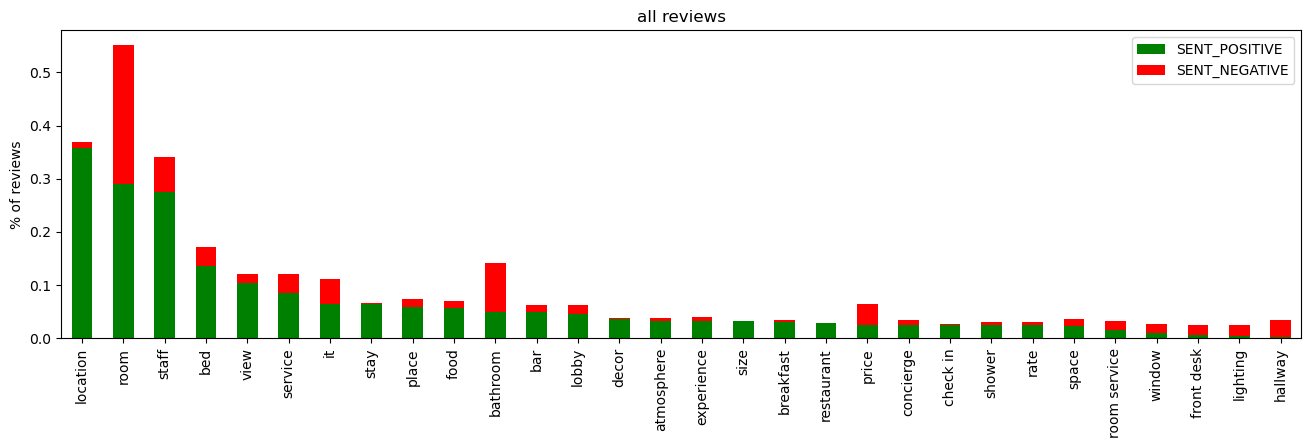

In [29]:
target_counts = plot_sentiment_to_targets(exp_sentiment_df, "all reviews")

You can also visualize the number of positive and negative mentions of a target for each hotel as follows:

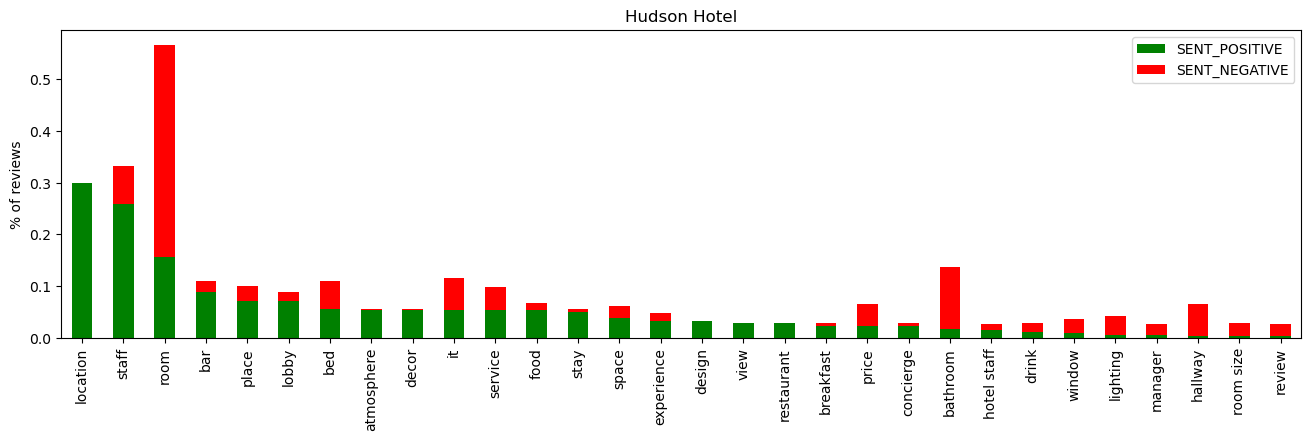

In [30]:
plot_sentiment_to_targets(exp_sentiment_df.query('Hotel == @hotel_a'), hotel_a)

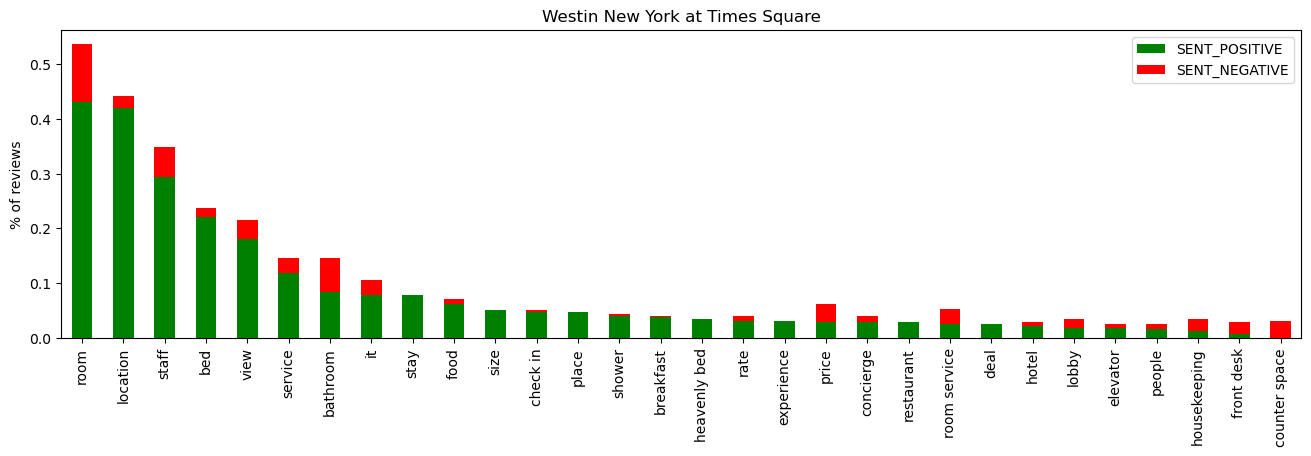

In [31]:
plot_sentiment_to_targets(exp_sentiment_df.query('Hotel == @hotel_b'), hotel_b)

##                                                           Thanks